In [1]:
from model.layers import Hough_Transform, AccumulationSpace  #, plot_hist
from data.labels import load_video, get_segmentation
from main import shrink_h
import cv2 as cv
import numpy as np
import time
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns

### Parameters
Setting parameters for all experiments below:

In [2]:
# shape of facet plane
h_plane = 5
w_plane = 5
# shape of Hough Space (not relevant for this notebook as we are only focusing on the facet planes)
HS_shape = (200, 200)

### Loading image
loading a simple example image without noise. 

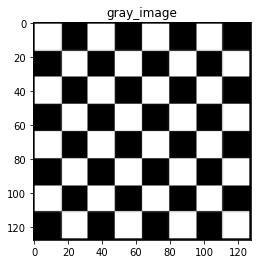

In [3]:
root = "data/"
#root = "C:/Users/HP/Documents/Uni/10.Semester/Pallet_detection/data/pallet/"
#filename = "diag_edge.jpg"
#filename = "edge.jpg"
#filename = "hallway.jpg"
filename = "chess.jpg"
path = os.path.join(root, filename)
img = cv.imread(path)

rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(rgb_img, cv.COLOR_RGB2GRAY)
gray = shrink_h(gray, 128)
gray = np.array(gray).astype(int)

plt.imshow(gray, cmap="gray")
plt.title("gray_image")
plt.show()

**Let's first look at the first example (origin at top left corner):**

In the resulting hough Space we see peaks for three different theta: 0 and -$\pi / 2$ and $\pi / 2$ (middle, upper and lower edge of the image). These numbers are correct, as we have lines in vertical (-$\pi / 2$ and $\pi / 2$) and horizontal (0 and -0) orientation. 

At zero degrees we observe a total of 9 Peaks, which is the total amount of horizontal lines. As $theta = arctan(\frac{\alpha}{\beta})$ an alpha of ~0 means theta is ~0 no matter if beta is positive or negative (bright to dark or dark to bright). So we have all nine horizontal lines on the same line in the hough space.

This is different for vertical lines as a beta of ~0 can mean either theta = inf or theta = - inf, if alpha is positive or negative respectively. So vertical lines are split into bright to dark (-$\pi / 2$) and dark to bright ($\pi / 2$). Due to the black frame of the chess board, the left line is only dark to bright and the line on the far right is only bright to dark. So we only have 8 lines each. This is visible in the Hough space. Note, that it can be seen better in graphs with lower bin size (see below).

The values for Rho vary at regular intervals between ~0 and ~120, which is correct as well, as the lines in the image occur at regular intervals as well with distances from 0 to 128 in vertical or horizontal direction.

**I also plotted some intermediate values and noticed something:**

Besides the expected results for the variance of rho and the covariance of theta and rho we can observe a diagonal line with low variance. In this image, the line is only unexpected at regions without variance, which have a gradient of 0. These regions have theta = $arctan(\frac{0 + \epsilon}{0 + \epsilon}) = \pi / 4$. So in this case: $sin(theta) = cos(theta)$

The formula $k = hi \cdot sin(theta) - wi \cdot cos(theta) = 0$, if hi = wi, which is true on the diagonal.

So $var_rho = k^2 \cdot var_theta + var_p = 0$ on the diagonal. (assuming var_p = 0*)

So the line is not coming from an error in the code but is eyplained by the formulas. The code is correct!

This line occurs only on positions on the diagonal where $alpha = beta$. But this should not happen right is it the missing var_p (see *) or did I forget something else?


*I forgot to ask you about this. But the paper did not give an answer how to set the positional variance, so I set it to zero, to get the code to work. But I think with larger facet planes the positional variance grows, as an edge is captured by more surrounding facet planes. This might also avoid the double peaks Ill describe below. (see section varying bin size).

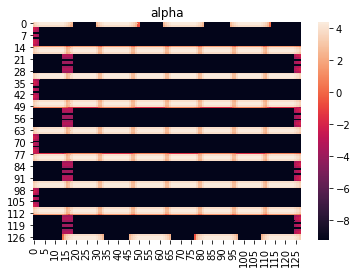

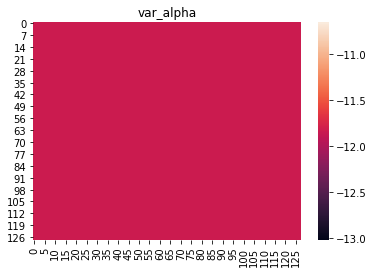

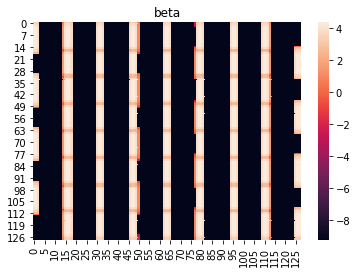

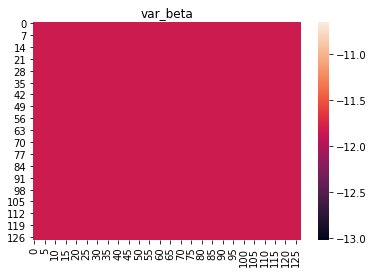

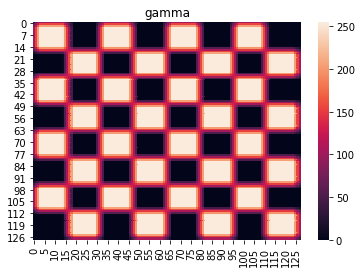

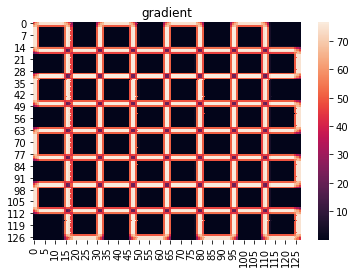

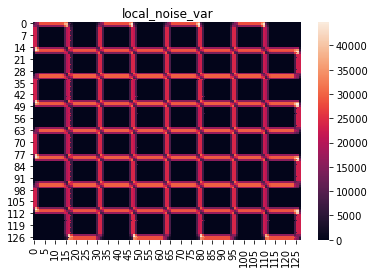

Noise Variance = 0.00036163094065376754


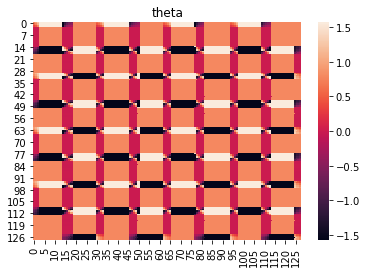

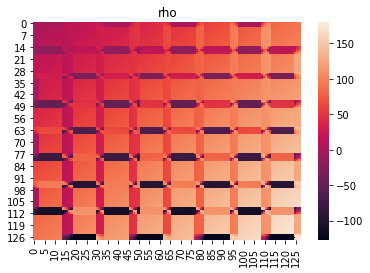

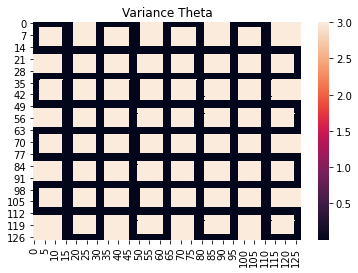

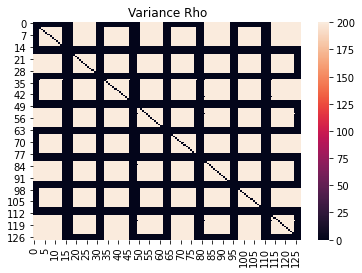

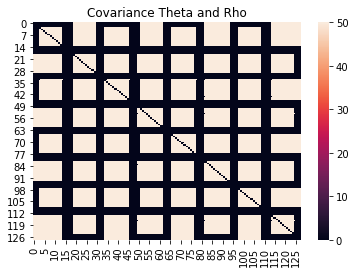

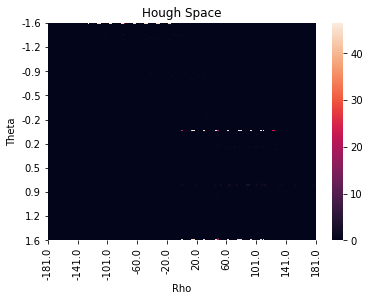

In [4]:
HT = Hough_Transform(input_dim=gray.shape, output_dim=HS_shape, h_plane=h_plane, w_plane=w_plane,
                    origin=(0,0))
acc_space = HT.forward(gray, visualize=True)
#acc_space.plot_values()

To check that the results are not totally wrong I plotted the lines using non-maxima surpression. I did not yet implement a better solution.

The lines are almost correct, but we detect some lines multiple times, with small shifting. I'll explain this in the section "varying binsize".

In [5]:
radius = 5
indices_local_maxima = np.array(acc_space.get_local_maxima(r=radius))
local_maxima_values = acc_space.values[indices_local_maxima[:, 0], indices_local_maxima[:, 1]]
threshold = 10
#print(local_maxima_values)

indices_lines = indices_local_maxima[local_maxima_values >= threshold]

theta_lines = acc_space.get_value_theta(indices_lines[:, 0])
rho_lines = acc_space.get_value_rho(indices_lines[:, 1])

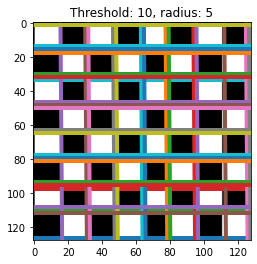

In [6]:
y = [0, img.shape[1] - 1] # y value boundaries (we only need two points per line)
x = np.zeros((len(theta_lines), 2))
for i in range(len(x)):
    for j in range(len(y)):
        # x-coordinates are calculated by polar coordinates of the lines
        x[i, j] = (rho_lines[i] - y[j] * np.sin(theta_lines[i]) ) / np.cos(theta_lines[i])
        # rho = x* cos(theta) + y*sin(theta)
    plt.plot(x[i], y, linewidth = 4)

plt.imshow(gray, cmap = "gray")
plt.title(f"Threshold: {threshold}, radius: {radius}")
plt.show()

### Varying origin
Visualizing the Hough Space for different origins on the diagonal of the image.

**Now let's compare the results for different origins:**

The further the origin moves towards the middle, the smaller the total displayed range, and the hough space is used more efficiently. This is because I scale the Houghspace based on the maximum possible rho. 
Using an origin at (0, 0) rho can be up to the whole diagonal of the image (This is e.g. the case for a line that only crosses the image at the lower right corner with a slope of one).
Using an origin at the center of the image, rho can only be up to half the images diagonal (For a line crossing at any corner of the image)

**Conclusion:**

We should place the origin in the middle of the image, if we want to use the Hough Space as efficient as possible. If we only care for the lines in a certain region (with known location), we might also consider placing the origin in the center of that region.

origin = (0, 0)


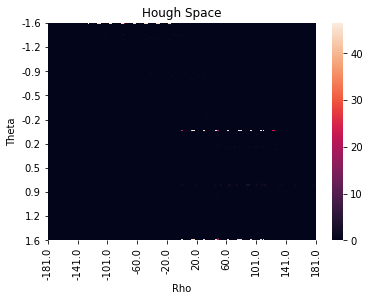

origin = (16, 16)


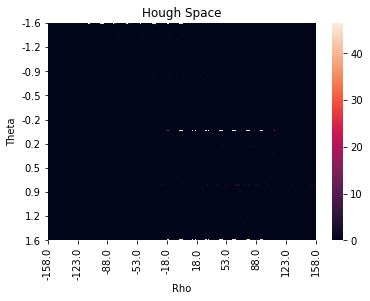

origin = (32, 32)


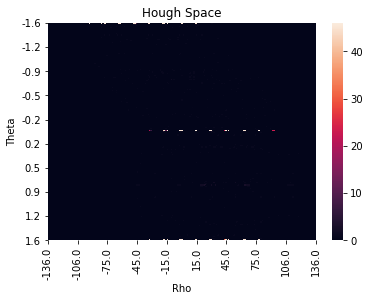

origin = (48, 48)


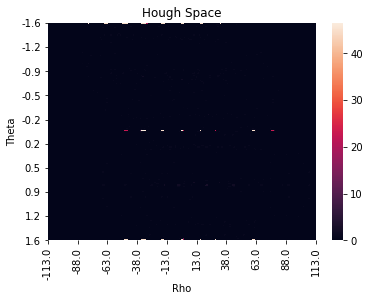

origin = (64, 64)


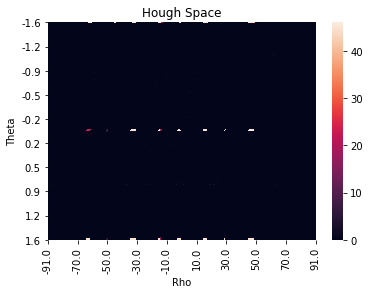

origin = (80, 80)


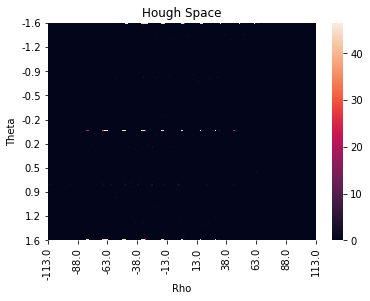

origin = (96, 96)


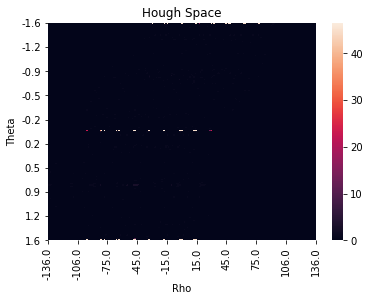

origin = (112, 112)


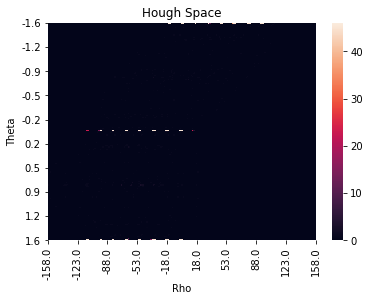

origin = (128, 128)


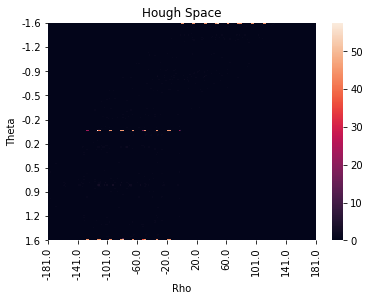

In [7]:
positions = range(0, 144, 16)
for pos in positions:
    print(f"origin = ({pos}, {pos})")
    HT = Hough_Transform(input_dim=gray.shape, output_dim=HS_shape, h_plane=h_plane, w_plane=w_plane,
                        origin=(pos, pos))
    acc_space = HT.forward(gray, visualize=False)
    acc_space.plot_values()

### Varying binsize
Experimenting with different binsizes. The binsizes are varied by changing the number of total bins. For this experiments I'm placing the origin in the center of the image.

The smaller the bins, the more precise the results. When the binsize is big (e.g. n_bins = 50) we get only one peak per edge (see explaination above). For very small binsizes (e.g. n_bins = 500) we can observe, that each peak is split into multiple smaller peaks. The resaon that is the size of the facet plane:

If the facet plane is e.g. 3x3 then a clean edge is detected at two positions orthogonal to the line, causing strong votes for two different rhos:

255 255 0                    

255 255 0  -> strong vote    

255 255 0  

But also:

255 0 0

255 0 0  -> strong vote

255 0 0

This error only occurs only to a magnitude of few pixels (depending on the size of the facet plane) and is only visible if the bins are small enough to display such a small difference. But this is the reason we detect the same line multiple times, using non maxima surpression (see above).

n_bins = 10
binsize theta = 0.3490658503988659
binsize rho = 20.113259553750687


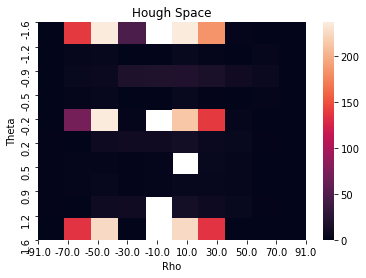

n_bins = 20
binsize theta = 0.16534698176788384
binsize rho = 9.527333472829273


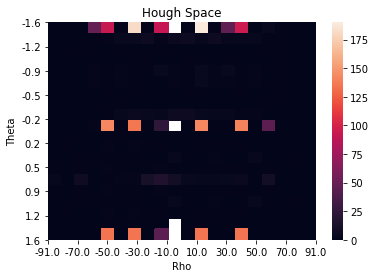

n_bins = 50
binsize theta = 0.0641141357875468
binsize rho = 3.6942721629337996


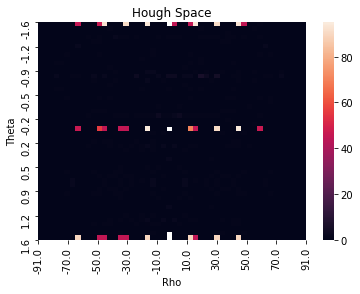

n_bins = 100
binsize theta = 0.03173325912716963
binsize rho = 1.8284781412500624


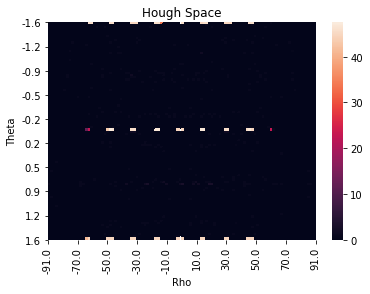

n_bins = 200
binsize theta = 0.01578689775673263
binsize rho = 0.9096449044409858


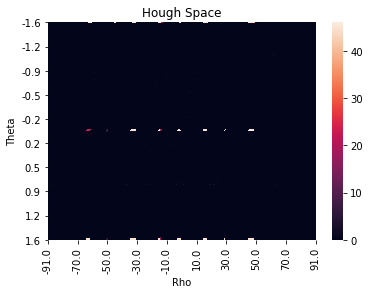

n_bins = 500
binsize theta = 0.006295776860901389
binsize rho = 0.36276420036824886


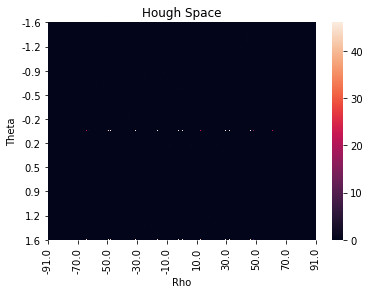

In [8]:
choices_n_bins = [10, 20, 50, 100, 200, 500]
for n_bins in choices_n_bins:
    HT = Hough_Transform(input_dim=gray.shape, output_dim=(n_bins, n_bins), h_plane=h_plane, w_plane=w_plane,
                        origin=(64, 64))
    acc_space = HT.forward(gray, visualize=False)
    print(f"n_bins = {n_bins}")
    print(f"binsize theta = {acc_space.theta_binsize}")
    print(f"binsize rho = {acc_space.rho_binsize}")
    acc_space.plot_values()